In [189]:
import pandas as pd
import seaborn as sns
import pylab as plt
import numpy as np
%matplotlib inline

d_country2iso = pd.read_csv("./data/countries_code.csv").set_index("Name").to_dict()["Code"]
EU = ["Austria","Belgium","Bulgaria","Croatia","Cyprus","Czech Republic","Denmark","Estonia","Finland","France","Germany","Greece","Hungary","Ireland","Italy","Latvia","Lithuania","Luxembourg","Malta","Netherlands","Poland","Portugal","Romania","Slovakia","Slovenia","Spain","Sweden","United Kingdom","Switzerland"]
EU = set([d_country2iso[x] for x in EU])

## 1. Format all

In [117]:
#Read data
df1 = pd.read_csv("data_taxes/Orbis_Export_3.txt",encoding="utf-16",sep="\t",index_col=0,na_values=["n.a.","n.s."],thousands=",")
df2 = pd.read_csv("data_taxes/Orbis_Export_4.txt",encoding="utf-16",sep="\t",index_col=0,na_values=["n.a.","n.s."],thousands=",")
df3 = pd.read_csv("data_taxes/Orbis_Export_5.txt",encoding="utf-16",sep="\t",index_col=0,na_values=["n.a.","n.s."],thousands=",")
df_raw = pd.concat([df1,df2,df3])



profit = df_raw.loc[:,["Company name","BvD ID number"] + ["P/L before tax th USD {}".format(year) for year in range(2007,2017)]]

tax = df_raw.loc[:,["Company name","BvD ID number"] + ["Tax th USD {}".format(year) for year in range(2007,2017)] + 
                 ["Taxation th USD {}".format(year) for year in range(2007,2017)]]

#Find how much money paid in taxes per year
for year in range(2007,2017):
    tax[year] = tax.loc[:,["Tax th USD {}".format(year),"Taxation th USD {}".format(year)]].max(1)
    profit[year] = profit["P/L before tax th USD {}".format(year)]

tax = pd.melt(tax,id_vars = ["Company name","BvD ID number"], value_vars=[2007,2008,2009,2010,2011,2012,2013,2014,2015,2016],var_name="year",value_name="tax")
profit = pd.melt(profit,id_vars = ["Company name","BvD ID number"], value_vars=[2007,2008,2009,2010,2011,2012,2013,2014,2015,2016],var_name="year",value_name="profit")
    
df = pd.merge(tax,profit,on=["Company name","BvD ID number","year"])

## 2. Average tax per year
- US companies are catching up, EU companies are paying less taxes
- However this is due to many companies not paying anytaxes or having any profits

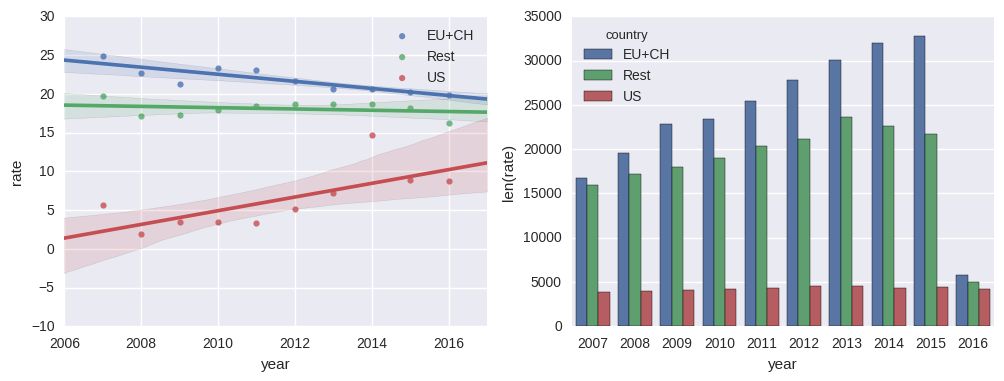

In [233]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
bycompany = df.copy()
bycompany["country"] = bycompany["BvD ID number"].apply(lambda x: x[:2])
bycompany["country"] = bycompany["country"].apply(lambda x: "US" if x == "US" else ("EU+CH" if x in EU else "Rest"))
bycompany["rate"] = bycompany["tax"]/bycompany["profit"]*100
for c,data in bycompany.groupby(["country"]):
    _ = data.groupby("year").median().reset_index()
    sns.regplot("year","rate",data=_,fit_reg=True,scatter=True,label=c)
plt.xlim(2006,2017)
plt.legend()

plt.subplot(1,2,2)
bycompany["year"] = bycompany["year"].astype(int)
sns.barplot(x="year",y="rate",data=bycompany.sort_values(by="country"),estimator=len,hue="country")


### only companies that made profits >1M

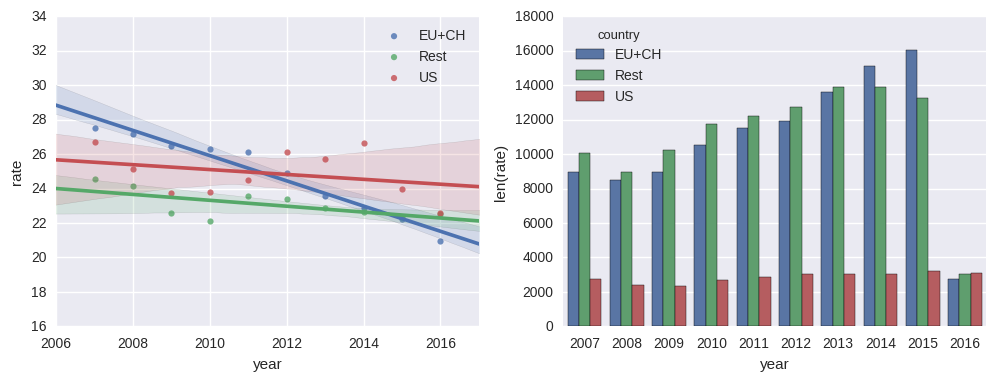

In [236]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
bycompany = df.copy()
bycompany = bycompany.loc[bycompany["profit"]>1000]
bycompany["country"] = bycompany["BvD ID number"].apply(lambda x: x[:2])
bycompany["country"] = bycompany["country"].apply(lambda x: "US" if x == "US" else ("EU+CH" if x in EU else "Rest"))
bycompany["rate"] = bycompany["tax"]/bycompany["profit"]*100
for c,data in bycompany.groupby(["country"]):
    _ = data.groupby("year").median().reset_index()
    sns.regplot("year","rate",data=_,fit_reg=True,scatter=True,label=c)
plt.xlim(2006,2017)
plt.legend()

plt.subplot(1,2,2)
bycompany["year"] = bycompany["year"].astype(int)
sns.barplot(x="year",y="rate",data=bycompany.sort_values(by="country"),estimator=len,hue="country")


## 3. Average tax per company 
- More US companies pay either more taxes or no taxes
- With time, more US companies are starting to pay some taxes. EU companies are moving towards paying less taxes

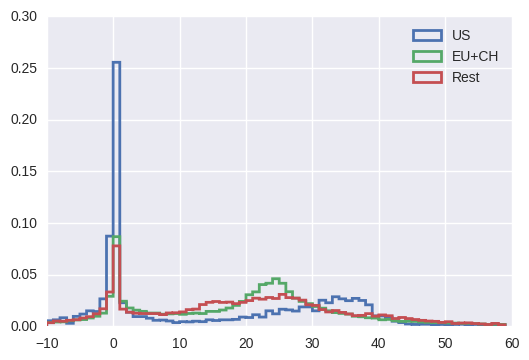

In [237]:
bycompany = df.groupby("BvD ID number").sum().reset_index()
bycompany["rate"] = bycompany["tax"]/bycompany["profit"]*100
bycompany["country"] = bycompany["BvD ID number"].apply(lambda x: x[:2])

x = bycompany.loc[bycompany["country"]=="US","rate"]
plt.hist(x[np.isfinite(x)],bins=range(-10,60),
         histtype="step", linewidth=2,  alpha=1,label="US",normed=True)


x = bycompany.loc[bycompany["country"].isin(EU),"rate"]
plt.hist(x[np.isfinite(x)],bins=range(-10,60),
         histtype="step", linewidth=2,  alpha=1,label="EU+CH",normed=True)

x = bycompany.loc[~bycompany["country"].isin(EU|{"US"}),"rate"]
plt.hist(x[np.isfinite(x)],bins=range(-10,60),
         histtype="step", linewidth=2,  alpha=1,label="Rest",normed=True)

plt.legend()
plt.show()

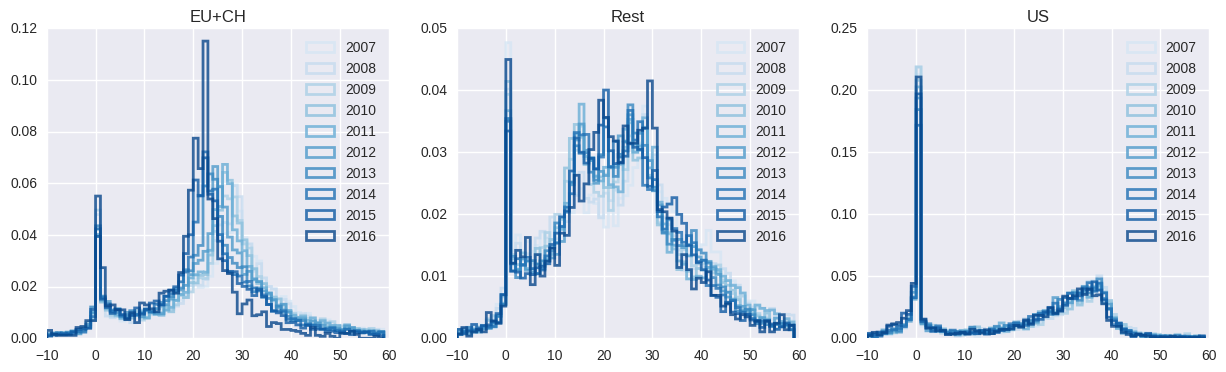

In [251]:
bycompany = df.copy()
bycompany = bycompany.loc[bycompany["profit"]>1000]
bycompany["country"] = bycompany["BvD ID number"].apply(lambda x: x[:2])
bycompany["country"] = bycompany["country"].apply(lambda x: "US" if x == "US" else ("EU+CH" if x in EU else "Rest"))
bycompany["rate"] = bycompany["tax"]/bycompany["profit"]*100


plt.figure(figsize=(15,4))
i = 0
for c,data in bycompany.groupby("country"):
    colors = sns.color_palette("Blues",11)[1:]
    i += 1
    plt.subplot(1,3,i)

    for year in range(2007,2017):
        x = data.loc[data["year"]==year,"rate"]
        plt.hist(x[np.isfinite(x)],bins=range(-10,60),
                 histtype="step", linewidth=2,  alpha=0.8,label=str(year),normed=True,color=colors.pop(0))
    plt.title(c)
    plt.legend()

## 4. Average tax per company size and country
- Only huge US companies pay taxes
- Those companies pay more taxes than their EU companies
- The distribution of profits for US companies is very weird!

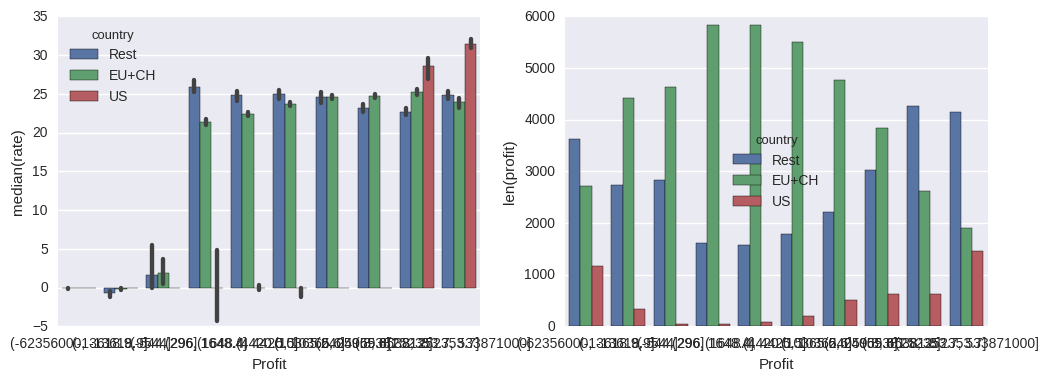

In [252]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
bycompany = df.groupby("BvD ID number").sum().reset_index()
bycompany["range"] = pd.cut(bycompany["profit"], np.percentile(bycompany["profit"],[0,10,20,30,40,50,60,70,80,90,100]))
bycompany["country"] = bycompany["BvD ID number"].apply(lambda x: x[:2])
bycompany["country"] = bycompany["country"].apply(lambda x: "US" if x == "US" else ("EU+CH" if x in EU else "Rest"))
bycompany["rate"] = bycompany["tax"]/bycompany["profit"]*100
sns.barplot(x="range",y="rate",data=bycompany,hue="country",estimator=np.median)
plt.xlabel("Profit")


plt.subplot(1,2,2)
bycompany = df.groupby("BvD ID number").sum().reset_index()
bycompany["range"] = pd.cut(bycompany["profit"], np.percentile(bycompany["profit"],[0,10,20,30,40,50,60,70,80,90,100]))
bycompany["country"] = bycompany["BvD ID number"].apply(lambda x: x[:2])
bycompany["country"] = bycompany["country"].apply(lambda x: "US" if x == "US" else ("EU+CH" if x in EU else "Rest"))
sns.barplot(x="range",y="profit",data=bycompany,hue="country",estimator=len)
plt.xlabel("Profit")
